<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_with_2_different_generators_and_1_Classifier_Good_Nandri_ver11%20int3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this is ensemble of 2 identical G

this step is to train each G seperately 

once each G generates meaniful results, then ensemble them

the way to train seperate is 
1) seperate train and load weights 
2) train with Avg (same G)


In [1]:
from IPython.display import Image
from keras.utils import plot_model
# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Using TensorFlow backend.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Double check with Python 3


In [0]:
# Restart runtime to allow Jupyter to know the changes above
import os
os._exit(0)

In [0]:
from IPython.display import Image
from keras.utils import plot_model

In [1]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files
import copy 

Using TensorFlow backend.


In [0]:
def load_dataold():
    (X_train, _), (_, _) = fashion_mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:56, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

In [0]:
##X_trainlarge = load_large_data()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:


def plotamodel(amodel, showdetails=True):
  # Model summary
  print(amodel.summary())

  if (showdetails==True):
    # Plot model graph
    plot_model(amodel, show_shapes=True, show_layer_names=True, to_file='model.png')
    Image(retina=True, filename='model.png')
  if (showdetails==False):
    # Plot model graph
    plot_model(amodel, show_shapes=False, show_layer_names=False, to_file='modelsmall.png')
    Image(retina=True, filename='modelsmall.png')

In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def train(generator1, generator2, discriminator, combined, mergedmodel,  epochs=2000, batch_size=128, save_interval=50, modeltotrain=1):

    X_train = load_databydatasetname(2)

    num_examples = X_train.shape[0] / 2
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)
    ##quater_batch = int(half_batch / 2) 

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise1 = np.random.normal(0, 1, (half_batch, 100))
            fake_images1 = generator1.predict(noise1)
            fake_labels1 = np.zeros((half_batch, 1))
            
           ## noise2 = np.random.normal(0, 1, (half_batch, 100))
            noise2 = copy.deepcopy(noise1)
            fake_images2 = generator2.predict(noise2)
            fake_labels2 = np.zeros((half_batch, 1))
            
            noise2 = copy.deepcopy(noise1)
            fake_images3 = mergedmodel.predict(noise2)
            fake_labels3 = np.zeros((half_batch, 1))            
            
           ## fake_images = np.append(fake_images1 , fake_images2, axis=0)
           ## fake_labels = np.append( fake_labels1 , fake_labels2, axis=0)
            
            if modeltotrain == 1:
              fake_images = fake_images1
              fake_labels = fake_labels1
            if modeltotrain == 2:
              fake_images = fake_images2
              fake_labels = fake_labels2
            if modeltotrain == 3:
              fake_images = fake_images3
              fake_labels = fake_labels3              
            
            if(batch == 0):
              print("G1 output numpy array shape")
              print(fake_images1.shape)
              print("G1+G2 appended numpy array shape")
              print(fake_images.shape)

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 100 == 0:
                 save_imgs(generator1, epoch, batch)
            if batch % 101 == 0:
                 save_imgs(generator2, epoch, batch)
            if batch % 102 == 0:
                 save_imgs(mergedmodel, epoch, batch)
                








In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_models():

    gen1_optimizer = Adam(lr=0.0002, beta_1=0.5)
    gen2_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer,  metrics=['accuracy'])

    generator1 = build_generator()
    
    generator2 = build_generator()

    z = Input(shape=(100,))
    img1 = generator1(z)
    img2 = generator2(z)
    merged = Average(getlastlayer(img1).output, getlastlayer(img2).output)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
    
    combined.summary()
    
    generator1.compile(loss='binary_crossentropy', optimizer=gen1_optimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=gen2_optimizer)
    
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined, mergedmodel

In [0]:
def build_modelsNEW(averagemode = 1, loadpretrainedweights=False):
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
    if(averagemode == 1):
          models = [generator1, generator1]
    if(averagemode == 2):
          models = [generator2, generator2]
    if(averagemode == 3):
          models = [generator1, generator2]


  ##  models = [generator1, generator2]
 ##   models = [generator1, generator1]
    outputs = [model.outputs[0] for model in models]
    merged = Average()(outputs)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
        

    
    if(loadpretrainedweights==True):
     # generator1 = generator1.load_weights('generator2fmnist.h5')
     # generator2 = generator2.load_weights('generator2fmnist.h5')
      generator1 = load_model('generator2fmnist.h5')
      generator2 = load_model('generator2fmnist.h5')
      

    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer) 
  
    #plotamodel(mergedmodel)
    plotamodel(combined)
    
    return generator1, generator2, discriminator, combined ,  mergedmodel

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 1 ,  loadpretrainedweights=False)


    
    

    


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

In [0]:
plotamodel(combined)
files.download('model.png')




In [0]:
#train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

In [0]:
!rm -rf generator1fminst.h5



In [0]:

generator1.save('generator1fminst.h5')



In [0]:
files.download('generator1fminst.h5')


In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 2 ,  loadpretrainedweights=False)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=20, modeltotrain=2)

In [0]:
!rm -rf generator2fmnist.h5


In [0]:

generator2.save('generator2fmnist.h5')

In [0]:
!ls -al


In [0]:
files.download('generator2fmnist.h5')

In [0]:
##!wget https://github.com/rajagopalmotivate/try1/raw/master/generatorTrainedepoch2git.h5

In [0]:
!rm -rf generator1fminst.h5

In [0]:
!ls -all

In [0]:
!wget https://github.com/rajagopalmotivate/try1/raw/master/generator1fminst.h5

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

In [0]:
plotamodel(combined, showdetails=True )
files.download('model.png')

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=1)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


Number of examples:  30000.0
Number of Batches:  937
Number of epochs:  2
G1 output numpy array shape
(16, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/937 [D loss: 0.847242, acc.: 40.62%] [G loss: 0.788973]


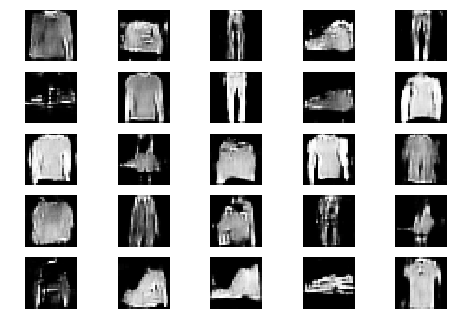

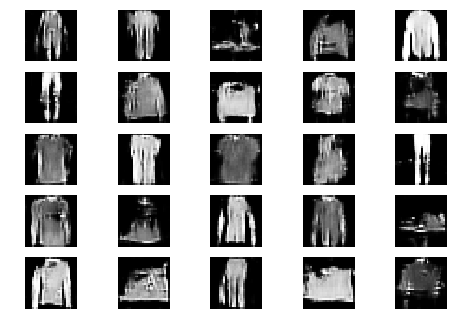

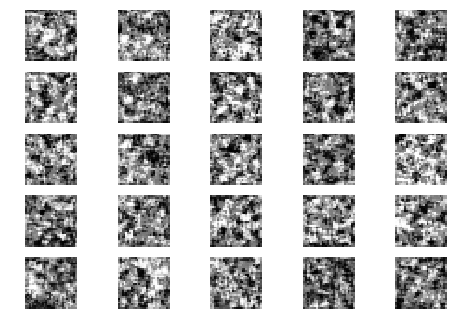

Epoch 0 Batch 1/937 [D loss: 0.679747, acc.: 65.62%] [G loss: 0.760382]
Epoch 0 Batch 2/937 [D loss: 0.562330, acc.: 75.00%] [G loss: 1.002090]
Epoch 0 Batch 3/937 [D loss: 0.730257, acc.: 56.25%] [G loss: 0.920785]
Epoch 0 Batch 4/937 [D loss: 0.448608, acc.: 81.25%] [G loss: 1.120829]
Epoch 0 Batch 5/937 [D loss: 0.627238, acc.: 68.75%] [G loss: 1.095930]
Epoch 0 Batch 6/937 [D loss: 0.499223, acc.: 75.00%] [G loss: 1.065459]
Epoch 0 Batch 7/937 [D loss: 0.457777, acc.: 78.12%] [G loss: 1.159026]
Epoch 0 Batch 8/937 [D loss: 0.444644, acc.: 75.00%] [G loss: 1.392778]
Epoch 0 Batch 9/937 [D loss: 0.523281, acc.: 78.12%] [G loss: 1.354187]
Epoch 0 Batch 10/937 [D loss: 0.436042, acc.: 84.38%] [G loss: 1.158080]
Epoch 0 Batch 11/937 [D loss: 0.424917, acc.: 81.25%] [G loss: 1.360909]
Epoch 0 Batch 12/937 [D loss: 0.374323, acc.: 84.38%] [G loss: 1.166520]
Epoch 0 Batch 13/937 [D loss: 0.432585, acc.: 84.38%] [G loss: 1.718015]
Epoch 0 Batch 14/937 [D loss: 0.550868, acc.: 62.50%] [G los

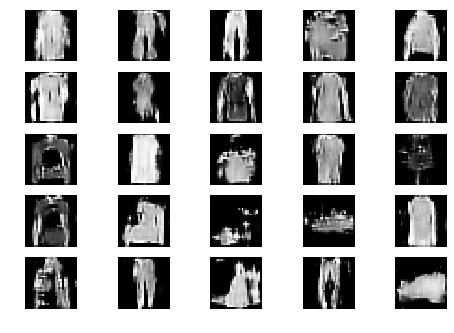

Epoch 0 Batch 101/937 [D loss: 0.763147, acc.: 59.38%] [G loss: 1.007643]


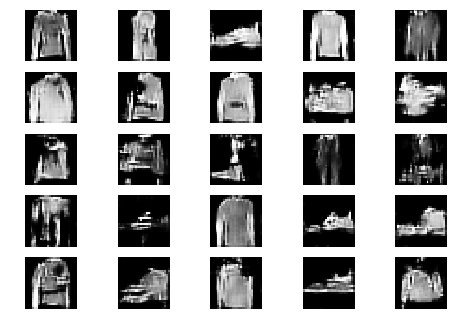

Epoch 0 Batch 102/937 [D loss: 0.509571, acc.: 75.00%] [G loss: 1.735656]


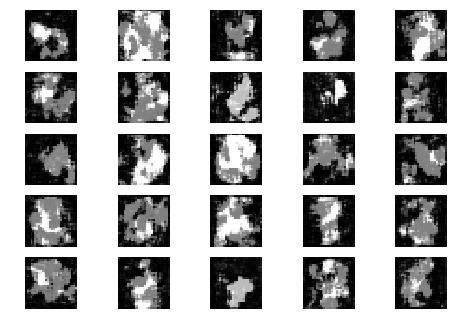

Epoch 0 Batch 103/937 [D loss: 0.899183, acc.: 43.75%] [G loss: 1.302637]
Epoch 0 Batch 104/937 [D loss: 0.760570, acc.: 68.75%] [G loss: 1.066372]
Epoch 0 Batch 105/937 [D loss: 0.615962, acc.: 68.75%] [G loss: 1.155670]
Epoch 0 Batch 106/937 [D loss: 0.710011, acc.: 71.88%] [G loss: 0.851835]
Epoch 0 Batch 107/937 [D loss: 0.570216, acc.: 65.62%] [G loss: 1.381312]
Epoch 0 Batch 108/937 [D loss: 0.754263, acc.: 53.12%] [G loss: 1.054330]
Epoch 0 Batch 109/937 [D loss: 0.526855, acc.: 71.88%] [G loss: 1.401833]
Epoch 0 Batch 110/937 [D loss: 0.746979, acc.: 50.00%] [G loss: 1.297405]
Epoch 0 Batch 111/937 [D loss: 0.468855, acc.: 75.00%] [G loss: 1.216792]
Epoch 0 Batch 112/937 [D loss: 0.866936, acc.: 46.88%] [G loss: 1.219345]
Epoch 0 Batch 113/937 [D loss: 0.797132, acc.: 46.88%] [G loss: 1.433256]
Epoch 0 Batch 114/937 [D loss: 0.760856, acc.: 53.12%] [G loss: 1.393716]
Epoch 0 Batch 115/937 [D loss: 0.672491, acc.: 65.62%] [G loss: 1.005722]
Epoch 0 Batch 116/937 [D loss: 0.79353

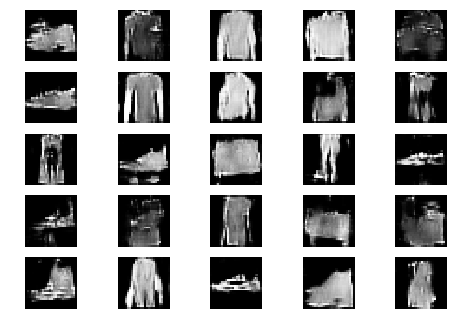

Epoch 0 Batch 201/937 [D loss: 0.625623, acc.: 65.62%] [G loss: 1.568747]
Epoch 0 Batch 202/937 [D loss: 0.495160, acc.: 75.00%] [G loss: 1.122547]


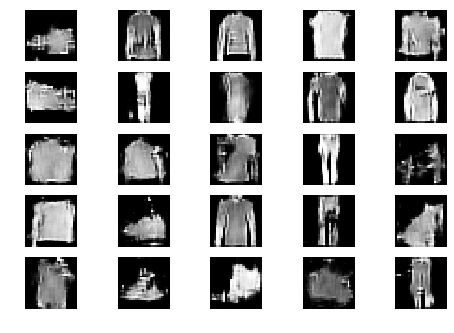

Epoch 0 Batch 203/937 [D loss: 0.636990, acc.: 56.25%] [G loss: 1.398764]
Epoch 0 Batch 204/937 [D loss: 0.543786, acc.: 71.88%] [G loss: 1.234658]


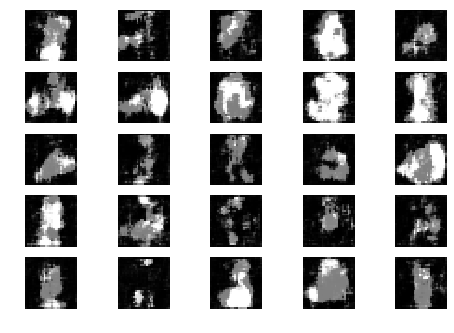

Epoch 0 Batch 205/937 [D loss: 0.390369, acc.: 81.25%] [G loss: 1.376459]
Epoch 0 Batch 206/937 [D loss: 0.547502, acc.: 71.88%] [G loss: 1.297151]
Epoch 0 Batch 207/937 [D loss: 0.567521, acc.: 68.75%] [G loss: 1.723936]
Epoch 0 Batch 208/937 [D loss: 0.689155, acc.: 65.62%] [G loss: 1.441158]
Epoch 0 Batch 209/937 [D loss: 0.678588, acc.: 62.50%] [G loss: 1.216077]
Epoch 0 Batch 210/937 [D loss: 0.570583, acc.: 56.25%] [G loss: 1.532954]
Epoch 0 Batch 211/937 [D loss: 0.537813, acc.: 68.75%] [G loss: 1.984698]
Epoch 0 Batch 212/937 [D loss: 0.746412, acc.: 62.50%] [G loss: 1.243805]
Epoch 0 Batch 213/937 [D loss: 0.592041, acc.: 65.62%] [G loss: 1.413679]
Epoch 0 Batch 214/937 [D loss: 0.506986, acc.: 68.75%] [G loss: 1.413352]
Epoch 0 Batch 215/937 [D loss: 0.681507, acc.: 68.75%] [G loss: 1.610565]
Epoch 0 Batch 216/937 [D loss: 0.639141, acc.: 68.75%] [G loss: 1.449877]
Epoch 0 Batch 217/937 [D loss: 0.704580, acc.: 68.75%] [G loss: 1.388810]
Epoch 0 Batch 218/937 [D loss: 0.70764

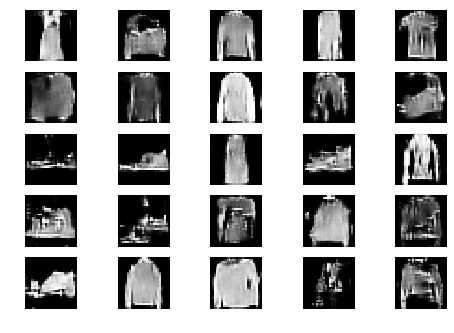

Epoch 0 Batch 301/937 [D loss: 0.478264, acc.: 81.25%] [G loss: 1.492446]
Epoch 0 Batch 302/937 [D loss: 0.461269, acc.: 78.12%] [G loss: 1.577834]
Epoch 0 Batch 303/937 [D loss: 0.495082, acc.: 78.12%] [G loss: 1.780178]


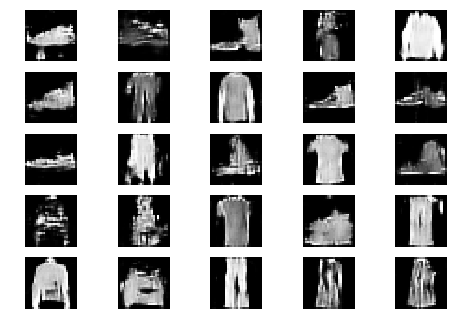

Epoch 0 Batch 304/937 [D loss: 0.503153, acc.: 81.25%] [G loss: 1.874221]
Epoch 0 Batch 305/937 [D loss: 0.553704, acc.: 71.88%] [G loss: 1.346881]
Epoch 0 Batch 306/937 [D loss: 0.404913, acc.: 84.38%] [G loss: 2.215486]


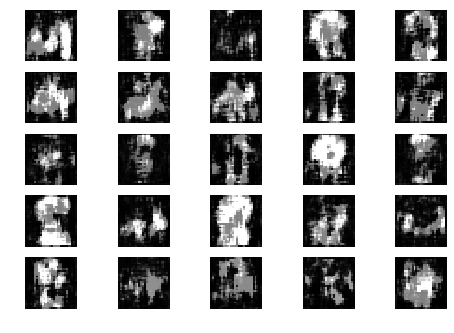

Epoch 0 Batch 307/937 [D loss: 0.732534, acc.: 56.25%] [G loss: 1.611719]
Epoch 0 Batch 308/937 [D loss: 0.491284, acc.: 71.88%] [G loss: 1.439640]
Epoch 0 Batch 309/937 [D loss: 0.500326, acc.: 71.88%] [G loss: 1.354759]
Epoch 0 Batch 310/937 [D loss: 0.441822, acc.: 84.38%] [G loss: 1.664262]
Epoch 0 Batch 311/937 [D loss: 0.321886, acc.: 90.62%] [G loss: 1.527969]
Epoch 0 Batch 312/937 [D loss: 0.515326, acc.: 78.12%] [G loss: 1.516440]
Epoch 0 Batch 313/937 [D loss: 0.482822, acc.: 68.75%] [G loss: 1.737453]
Epoch 0 Batch 314/937 [D loss: 0.548908, acc.: 71.88%] [G loss: 1.872195]
Epoch 0 Batch 315/937 [D loss: 0.466837, acc.: 81.25%] [G loss: 1.730884]
Epoch 0 Batch 316/937 [D loss: 0.447472, acc.: 81.25%] [G loss: 1.764570]
Epoch 0 Batch 317/937 [D loss: 0.368055, acc.: 84.38%] [G loss: 1.810785]
Epoch 0 Batch 318/937 [D loss: 0.505716, acc.: 71.88%] [G loss: 1.426144]
Epoch 0 Batch 319/937 [D loss: 0.537620, acc.: 78.12%] [G loss: 1.414898]
Epoch 0 Batch 320/937 [D loss: 0.53819

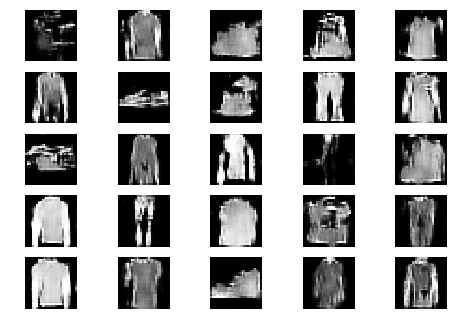

Epoch 0 Batch 401/937 [D loss: 0.499378, acc.: 87.50%] [G loss: 2.026685]
Epoch 0 Batch 402/937 [D loss: 0.490736, acc.: 78.12%] [G loss: 2.571691]
Epoch 0 Batch 403/937 [D loss: 0.216281, acc.: 93.75%] [G loss: 2.332356]
Epoch 0 Batch 404/937 [D loss: 0.466430, acc.: 65.62%] [G loss: 2.064156]


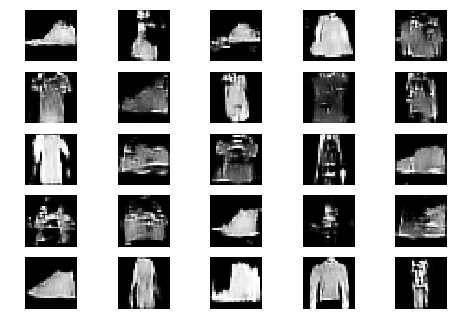

Epoch 0 Batch 405/937 [D loss: 0.478347, acc.: 75.00%] [G loss: 1.670998]
Epoch 0 Batch 406/937 [D loss: 0.352787, acc.: 81.25%] [G loss: 2.295398]
Epoch 0 Batch 407/937 [D loss: 0.307434, acc.: 93.75%] [G loss: 2.296633]
Epoch 0 Batch 408/937 [D loss: 0.377077, acc.: 87.50%] [G loss: 1.884530]


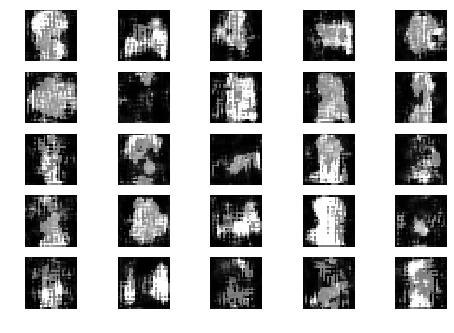

Epoch 0 Batch 409/937 [D loss: 0.381381, acc.: 84.38%] [G loss: 2.207416]
Epoch 0 Batch 410/937 [D loss: 0.717494, acc.: 56.25%] [G loss: 2.583513]
Epoch 0 Batch 411/937 [D loss: 0.571610, acc.: 71.88%] [G loss: 2.442805]
Epoch 0 Batch 412/937 [D loss: 0.628528, acc.: 75.00%] [G loss: 1.288771]
Epoch 0 Batch 413/937 [D loss: 0.559036, acc.: 68.75%] [G loss: 1.783525]
Epoch 0 Batch 414/937 [D loss: 0.507518, acc.: 84.38%] [G loss: 2.132336]
Epoch 0 Batch 415/937 [D loss: 0.792880, acc.: 62.50%] [G loss: 2.026189]
Epoch 0 Batch 416/937 [D loss: 0.346911, acc.: 87.50%] [G loss: 2.222185]
Epoch 0 Batch 417/937 [D loss: 0.685331, acc.: 71.88%] [G loss: 1.370736]
Epoch 0 Batch 418/937 [D loss: 0.841311, acc.: 53.12%] [G loss: 1.407234]
Epoch 0 Batch 419/937 [D loss: 0.301568, acc.: 90.62%] [G loss: 1.605303]
Epoch 0 Batch 420/937 [D loss: 0.441562, acc.: 78.12%] [G loss: 1.924361]
Epoch 0 Batch 421/937 [D loss: 0.664094, acc.: 59.38%] [G loss: 2.057571]
Epoch 0 Batch 422/937 [D loss: 0.78936

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
plotamodel(combined)
files.download('model.png')

In [0]:
!rm -rf generatorTrainedepoch2.h5

generator1.save('generator1fminst.h5')

!rm -rf generator2Trainedepoch2.h5

generator2.save('generator2fminst.h5')


In [52]:
generator1 = generator1.load_weights('generator1fmnist.h5')

OSError: ignored

In [51]:
generator2 = generator2.load_weights('generator2fmnist.h5')

AttributeError: ignored

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

In [0]:
generator1.save('generatorTrained1epoch4.h5')

In [0]:
files.download('generator1fmnist.h5')

In [0]:
files.download('generator2fmnist.h5')

In [0]:
##files.download('discriminator1.h5')

In [0]:
##files.download('combined1.h5')

In [0]:
#generator1 = load_model('generator1.h5')
#discriminator1 = load_model('discriminator1.h5')
#combined1 = load_model('combined1.h5')

